In [33]:
import pandas as pd
import numpy as np
import cupy as cp

import time

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss

import warnings
warnings.filterwarnings('ignore')

### Data

In [2]:
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
           "thalach", "exang", "oldpeak", "slope", "ca","thal","num"]

df = pd.DataFrame(columns=columns)

with open("data/processed.cleveland.data", "r") as f:
    for line in f.readlines():
        line = line.split(",")
        line[-1] = line[-1][:-1]
        line = [float(l) if l[0].isnumeric() else None for l in line ]
        df.loc[df.shape[0]] = line


In [3]:
# Remove NaN
for ind in df.index:
    for column in df.columns:
        if np.isnan(df.at[ind, column]):
            df.at[ind, column] = df[column][~df[column].isna()].mean()

In [4]:
# Normalize
for column in df.columns:
    df[column] = df[column]/df[column].mean()

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,1.157260,1.470874,0.316614,1.101073,0.944493,6.733333,2.02,1.002625,0.000000,2.212381,1.874227,0.000000,1.267368,0.000000
1,1.230737,1.470874,1.266458,1.214977,1.159335,0.000000,2.02,0.721890,3.060606,1.442857,1.249485,4.462687,0.633684,2.133803
2,1.230737,1.470874,1.266458,0.911233,0.928279,0.000000,2.02,0.862258,3.060606,2.500952,1.249485,2.975124,1.478596,1.066901
3,0.679661,1.470874,0.949843,0.987169,1.013405,0.000000,0.00,1.249939,0.000000,3.366667,1.874227,0.000000,0.633684,0.000000
4,0.753137,0.000000,0.633229,0.987169,0.826939,0.000000,2.02,1.149677,0.000000,1.346667,0.624742,0.000000,0.633684,0.000000


In [6]:
df.shape

(303, 14)

In [7]:
# Feature matrix and target
X_ar, y_ar = np.array(df)[:,:-1], np.array(df, dtype=int)[:,-1]

## Experiments

In [8]:
accuracy, training_time = {}, {}

### Sklearn

In [9]:
from sklearn.linear_model import LogisticRegression as LogisticRegression_sklearn

In [10]:
clf = LogisticRegression_sklearn()

start = time.time()
clf.fit(X_ar, y_ar)
training_time["sklearn"] = time.time() - start 

/home/artem/.conda/envs/pytorch1_3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/artem/.conda/envs/pytorch1_3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [11]:
accuracy["sklearn"] = clf.score(X_ar, y_ar)

### Numpy

In [12]:
from logistic_regression_numpy_cupy import LogisticRegression_py

In [13]:
clf = LogisticRegression_py(5, xp=np)

start = time.time()
clf.fit(X_ar, y_ar, num_itr=100, lr=1e-4)
training_time["numpy"] = time.time() - start 

In [14]:
accuracy["numpy"] = clf.score(X_ar, y_ar)

### Numpy loop

In [15]:
from logistic_regression_numpy_loop import forward_loop, score_loop

In [17]:
start = time.time()
W = forward_loop(X_ar, y_ar, lr=1e-4, show_train=False)
training_time["numpy - loop"] = time.time() - start 

In [18]:
accuracy["numpy - loop"] = score_loop(X_ar, y_ar, W)

### Cupy

In [19]:
clf = LogisticRegression_py(5, xp=cp)

start = time.time()
clf.fit(X_ar, y_ar, num_itr=100, lr=1e-4)
training_time["cupy"] = time.time() - start 

In [20]:
accuracy["cupy"] = clf.score(X_ar, y_ar)

### Torch - 1GPU

In [21]:
from logistic_regression_torch import LogisticRegression_torch, train_torch, score_torch

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
clf_torch = LogisticRegression_torch(num_features=X_ar.shape[1], 
                                     num_classes=5)
clf_torch = clf_torch.to(device)

criterion = BCEWithLogitsLoss()
optimizer = SGD(clf_torch.parameters(), lr=1e-1)

In [24]:
start = time.time()

train_torch(clf_torch, criterion, optimizer, X_ar, y_ar, 
            num_itr=100, device=device)

training_time["torch - 1GPU"] = time.time() - start 

In [25]:
accuracy["torch - 1GPU"] = score_torch(clf_torch, X_ar, y_ar, device=device)

### Torch - 2GPU

In [26]:
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 2 GPUs!


In [27]:
clf_torch = LogisticRegression_torch(num_features=X_ar.shape[1], 
                                     num_classes=5)
clf_torch = clf_torch.to(device)

# Paralleling
clf_torch_multi = nn.DataParallel(clf_torch)

criterion = BCEWithLogitsLoss()
optimizer = SGD(clf_torch_multi.parameters(), lr=1e-1)

In [28]:
start = time.time()
train_torch(clf_torch_multi, criterion, optimizer, X_ar, y_ar, 
            num_itr=100, device=device)
training_time["torch - 2GPU"] = time.time() - start 

In [29]:
accuracy["torch - 2GPU"] = score_torch(clf_torch, X_ar, y_ar, device=device)

### Numba

In [30]:
from numba import jit

In [31]:
forward_loop_jit = jit()(forward_loop)
score_loop_jit = jit()(score_loop)

In [34]:
start = time.time()
W = forward_loop_jit(X_ar, y_ar, lr=1e-4, show_train=False)
training_time["numba"] = time.time() - start 

In [35]:
accuracy["numba"] = score_loop_jit(X_ar, y_ar, W)

## Vizualization

Text(0.5, 1.0, 'Training time of different methods')

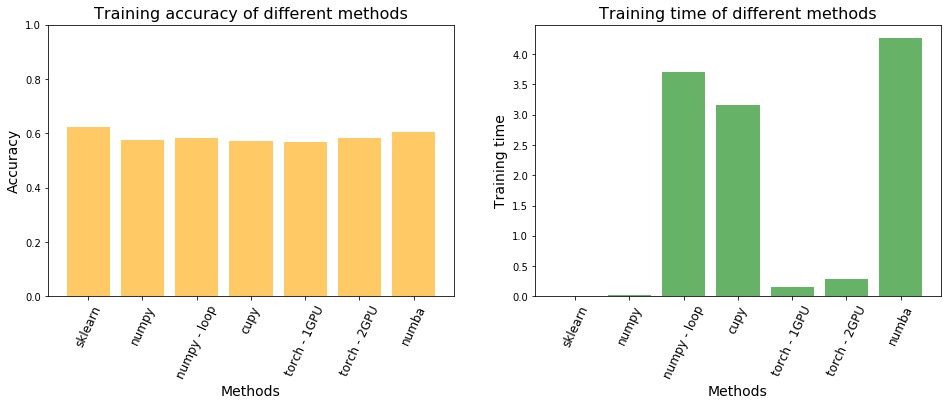

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].bar(accuracy.keys(), accuracy.values(), alpha=0.6, color="orange")
ax[0].set_ylim(0., 1.)

ax[1].bar(training_time.keys(), training_time.values(), alpha=0.6, color="green")

ax[0].set_ylabel("Accuracy", fontsize=14)
ax[1].set_ylabel("Training time", fontsize=14)

for i in range(2):
    ax[i].set_xlabel("Methods", fontsize=14)
    ax[i].set_xticklabels(training_time.keys(), rotation=65, fontsize=12)

ax[0].set_title("Training accuracy of different methods", fontsize=16)
ax[1].set_title("Training time of different methods", fontsize=16)